In [1]:
!pip install contractions

In [2]:
import pandas as pd
import wordcloud as WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from collections import Counter
import re
import nltk

from nltk.tokenize import RegexpTokenizer
import contractions

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanshudhande/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/himanshudhande/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('train.csv', header = None,nrows=3000000)
df.columns = ['Rating', 'Title', 'Review']
df.head(10)

,Rating,Title,Review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


In [4]:
df.shape

(3000000, 3)

In [5]:
df = df[['Rating', 'Review']].reset_index(drop=True)

In [6]:
def decrease_label_by_one(label):
    return label - 1

df['Rating'] = df['Rating'].apply(decrease_label_by_one)

In [7]:
df.head()

,Rating,Review
0,1,This sound track was beautiful! It paints the ...
1,1,I'm reading a lot of reviews saying that this ...
2,1,This soundtrack is my favorite music of all ti...
3,1,I truly like this soundtrack and I enjoy video...
4,1,"If you've played the game, you know how divine..."


In [8]:
df.Rating.value_counts(normalize = True)

Rating
1    0.50099
0    0.49901
Name: proportion, dtype: float64

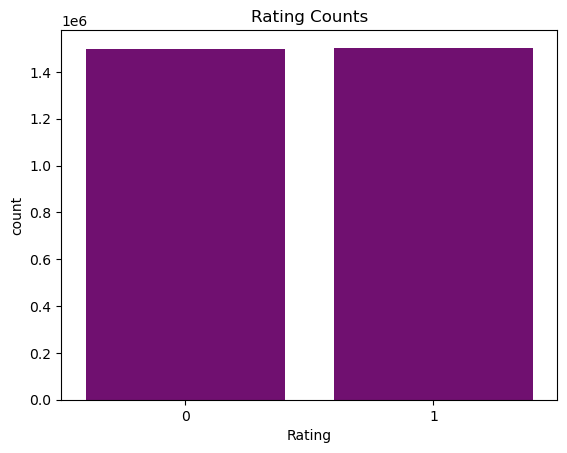

In [9]:
color_palette = ['purple', 'cyan']
sns.set_palette(color_palette) 
sns.countplot(x=df['Rating'])

plt.title('Rating Counts')
plt.show()

In [10]:
df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [11]:
def preprocess_text(text):
    # Text clean
    text = re.sub(r'[\W_]+', ' ', contractions.fix(re.sub(r'\d+', '', text.replace(' s ', ' ')))).lower()

    # Stopword removal
    tokens = nltk.word_tokenize(text)
    text = " ".join([token for token in tokens if token not in stop_words])

    # Data Normalization
    normalized_text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(normalized_text)

    return text

In [12]:
print(colored('Before of clean:\n', 'blue'), df.Review[9])
print(colored('After of clean:\n', 'blue'), preprocess_text(df.Review[9]))

Before of clean:
 This was a easy to read book that made me want to keep reading on and on, not easy to put down.It left me wanting to read the follow on, which I hope is coming soon. I used to read a lot but have gotten away from it. This book made me want to read again. Very enjoyable.
After of clean:
 easi read book made want keep read easi put left want read follow hope come soon use read lot gotten away book made want read enjoy


In [13]:
df['Review'] = df['Review'].apply(preprocess_text)

In [14]:
df.head(10)

,Rating,Review
0,1,sound track beauti paint seneri mind well woul...
1,1,read lot review say best game soundtrack figur...
2,1,soundtrack favorit music time hand intens sad ...
3,1,truli like soundtrack enjoy video game music p...
4,1,play game know divin music everi singl song te...
5,1,quit sure actual take time read play game leas...
6,0,self publish book want know read paragraph sta...
7,1,love whisper wick saint stori amaz pleasant su...
8,1,finish read whisper wick saint fell love carac...
9,1,easi read book made want keep read easi put le...


In [15]:
words = Counter(' '.join(df['Review'].to_list()).split())
Frequency_words = pd.DataFrame([words]).transpose().reset_index().rename(columns = {'index': 'Words', 0:'Frequency' })
Frequency_words = Frequency_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Frequency_words['Rank'] = Frequency_words['Rank'].apply(lambda x : x+1)
Frequency_words.head(20)

,Rank,Words,Frequency
0,1,book,1730180
1,2,one,1145925
2,3,like,948086
3,4,would,845126
4,5,read,759224
5,6,good,714741
6,7,get,709070
7,8,use,702716
8,9,great,681561
9,10,time,680954


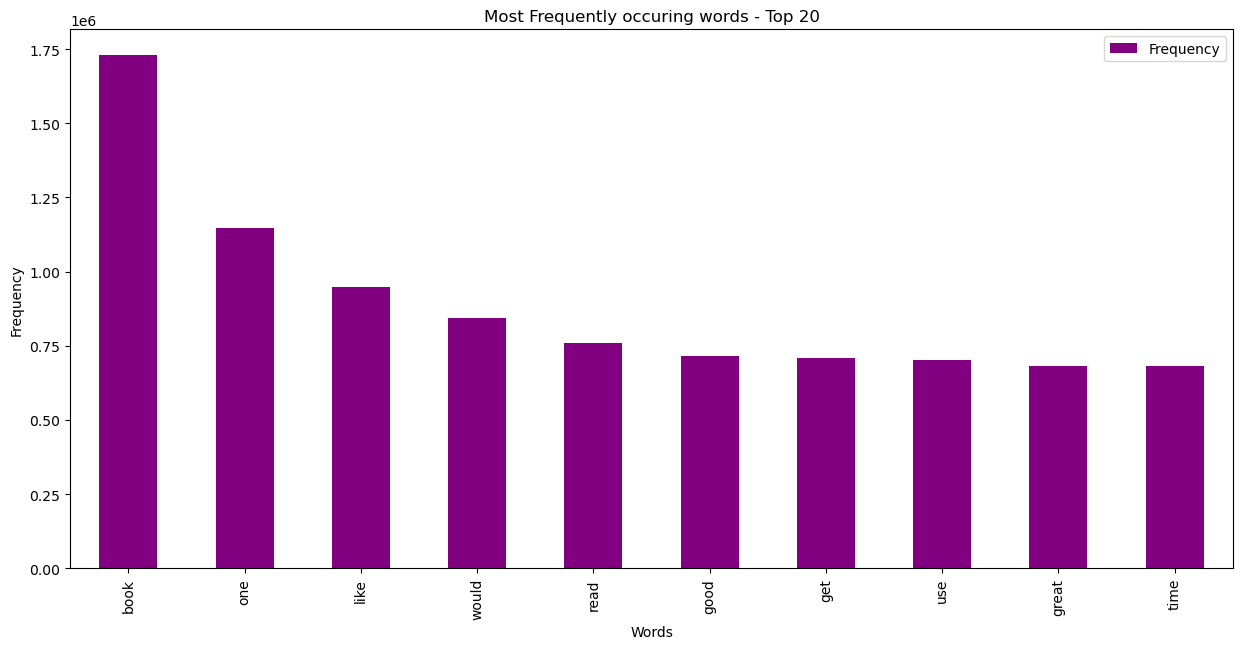

In [16]:
Top10 = Frequency_words[['Words','Frequency']].head(10)
Top10.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'purple')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

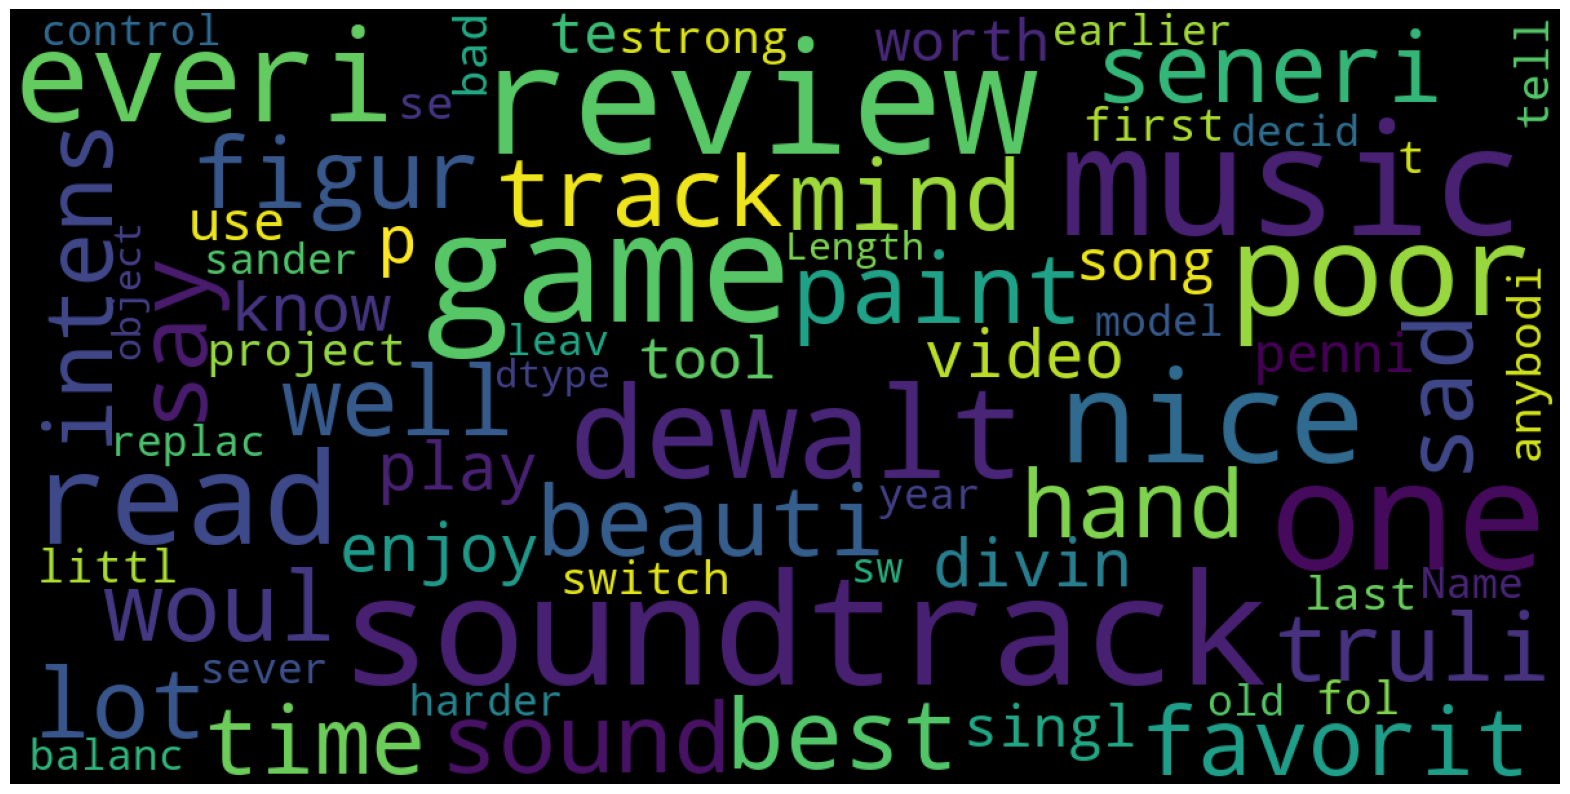

In [17]:
from wordcloud import WordCloud
#  WordCloud chart 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df["Review"])

In [18]:
Tf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer ='char')
Tf

TfidfVectorizer(analyzer='char', max_features=20000, ngram_range=(1, 3))

In [19]:
X = Tf.fit_transform(df['Review'])
y = df['Rating']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [21]:
lr = LogisticRegression(max_iter=5000)

# Define the preprocessing steps for numeric features
lr.fit(X_train, y_train)

# Evaluate the model on the testing data
lr_preds = lr.predict(X_test)

# Evaluate the accuracy of the model
lr_accuracy = accuracy_score(y_test, lr_preds)*100
print(f"Accuracy of Linear Regression Model: {lr_accuracy:.2f}%")

Accuracy of Linear Regression Model: 83.79%


In [22]:
svm = LinearSVC()

# Define the preprocessing steps for numeric features
svm.fit(X_train, y_train)

# Predict the ratings for the test set
svm_preds = svm.predict(X_test)

# Evaluate the accuracy of the model
svm_accuracy = accuracy_score(y_test, svm_preds)*100
print(f"Accuracy of SVM Model: {svm_accuracy:.2f}%")

Accuracy of SVM Model: 83.91%


In [23]:
def predict_sentiment(comment, vectorizer, model):
    vec = vectorizer.transform([comment])
    prediction = model.predict(vec)
    
    if prediction == 0:
        print(colored("Negative", "red"))
    else:
        print(colored("Positive", "blue"))

In [24]:
x = "Best."
predict_sentiment(x, Tf, lr)

Positive


In [25]:
x = " there are some defect  "
predict_sentiment(x, Tf, lr)

Negative


In [26]:
dft = pd.read_csv('test.csv',nrows = 10)
df.columns = ['Rating', 'Review']
df.head(10)
                   

,Rating,Review
0,1,sound track beauti paint seneri mind well woul...
1,1,read lot review say best game soundtrack figur...
2,1,soundtrack favorit music time hand intens sad ...
3,1,truli like soundtrack enjoy video game music p...
4,1,play game know divin music everi singl song te...
5,1,quit sure actual take time read play game leas...
6,0,self publish book want know read paragraph sta...
7,1,love whisper wick saint stori amaz pleasant su...
8,1,finish read whisper wick saint fell love carac...
9,1,easi read book made want keep read easi put le...


In [27]:
for index, row in dft.head(10).iterrows():
    x = row[2]
    prediction = predict_sentiment(x, Tf, lr)
    print(f"Review: {x}")
    print("------------------------")

Positive
Review: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.
------------------------
Negative
Review: I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline